<a href="https://colab.research.google.com/github/nikitaoltyan/ML-Homework/blob/main/Assignment4/PyTorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 4.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  


In [1]:
# Запустите эту ячейку если работаете в Colab
import os
if not os.path.exists('PyTorch_CNN.ipynb'):
    !git clone https://github.com/nikitaoltyan/ML-Homework.git
%cd ML-Homework/data

Cloning into 'ML-Homework'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 381 (delta 45), reused 0 (delta 0), pack-reused 277
Receiving objects: 100% (381/381), 1.59 MiB | 9.88 MiB/s, done.
Resolving deltas: 100% (161/161), done.
/content/ML-Homework/data


In [2]:
! wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
%cd ../Assignment4

--2021-03-22 07:46:25--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  75.4MB/s    in 2.3s    

2021-03-22 07:46:27 (75.4 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-03-22 07:46:27--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  95.3MB/s    in 0.6s    

2021-03-22 07:46:28 (95.3 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-03-22 07:46:28--
Total wall clock time: 3.1s
Downloaded: 2 files, 235M i

In [3]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [4]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [5]:
# First, lets load the dataset
data_train = dset.SVHN('../data',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('../data', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [7]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [8]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [9]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

from torch.autograd import Variable
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    num_correct = 0
    num_samples = 0
    for x, y in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        scores = model(x_gpu)
        preds = torch.argmax(scores, 1)
        num_correct += (preds == y_gpu).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    
    return acc

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.483339, Train accuracy: 0.500819, Val accuracy: 0.673538
Average loss: 0.728289, Train accuracy: 0.776985, Val accuracy: 0.800014
Average loss: 0.618421, Train accuracy: 0.814029, Val accuracy: 0.810047
Average loss: 0.570032, Train accuracy: 0.828721, Val accuracy: 0.808750
Average loss: 0.530343, Train accuracy: 0.840955, Val accuracy: 0.843970


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [24]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN("../data/", transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


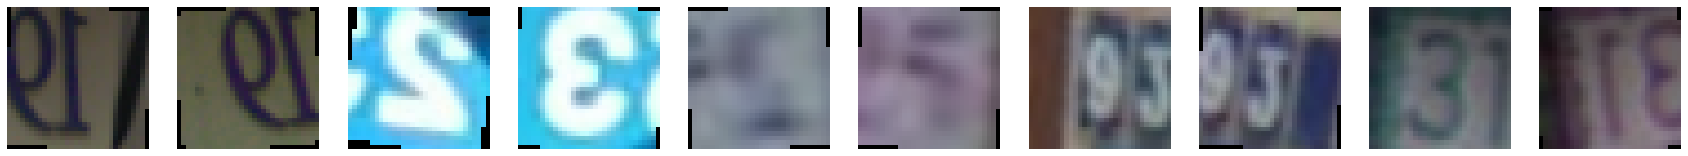

In [25]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('../data/', transform=tfs)

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [30]:
# TODO:
# Horizontaly and Verticaly rotated images are useless in numbers classification.
# This rotations are difficult to perform irl. I think we can put it aside.
tfs = transforms.Compose([
    # TODO: Add good augmentations
    # For different color-corrections and poor light conditions.
    transforms.ColorJitter(hue=0.5, saturation=0.5, brightness=0.5, contrast=0.5),
    # For small rotations, because numbers are rarely found at right angles irl.
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])                            
])

# TODO create new instances of loaders with the augmentations you chose
train_aug_data = dset.SVHN('../data/', transform=tfs)
train_aug_loader = torch.utils.data.DataLoader(train_aug_data, batch_size=batch_size, 
                                               sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [31]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.687011, Train accuracy: 0.793554, Val accuracy: 0.828203
Average loss: 0.623056, Train accuracy: 0.812630, Val accuracy: 0.839397
Average loss: 0.605334, Train accuracy: 0.817698, Val accuracy: 0.844447
Average loss: 0.587247, Train accuracy: 0.824079, Val accuracy: 0.848748
Average loss: 0.574529, Train accuracy: 0.828362, Val accuracy: 0.849976


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [32]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
                nn.Conv2d(3, 6, 5),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(6, 16, 5),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),    
                Flattener(),
                nn.Linear(400, 120),
                nn.ReLU(inplace=True),
                nn.Linear(120, 84),
                nn.ReLU(inplace=True),
                nn.Linear(84, 10),
                nn.LogSoftmax(dim=-1)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [33]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.512768, Train accuracy: 0.484643, Val accuracy: 0.778104
Average loss: 0.622347, Train accuracy: 0.813296, Val accuracy: 0.840966
Average loss: 0.512803, Train accuracy: 0.845306, Val accuracy: 0.869770
Average loss: 0.461858, Train accuracy: 0.860236, Val accuracy: 0.866562
Average loss: 0.430890, Train accuracy: 0.871293, Val accuracy: 0.889973
Average loss: 0.402917, Train accuracy: 0.879586, Val accuracy: 0.887311
Average loss: 0.383017, Train accuracy: 0.885046, Val accuracy: 0.890246
Average loss: 0.362114, Train accuracy: 0.890028, Val accuracy: 0.897686
Average loss: 0.350381, Train accuracy: 0.893407, Val accuracy: 0.849430
Average loss: 0.341067, Train accuracy: 0.895932, Val accuracy: 0.895570


# Подбор гиперпараметров

In [25]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [5, 10, 15, 20, 30]
regularizations = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

tfs = transforms.Compose([
    transforms.ColorJitter(hue=0.5, saturation=0.5, brightness=0.5, contrast=0.5),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])                            
])
train_aug_data = dset.SVHN('../data/', transform=tfs)
train_aug_loader = torch.utils.data.DataLoader(train_aug_data, batch_size=batch_size, 
                                               sampler=train_sampler)
# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!

num_of_iters = 5
for iter in range (num_of_iters):
  lr = np.random.uniform(learning_rates[-1], learning_rates[0])
  reg = np.random.uniform(regularizations[-1], regularizations[0])
  epochs = np.random.random_integers(anneal_epochs[0], anneal_epochs[-1])
  print(f"Iter {iter} || lr: {lr} || reg: {reg} || epochs: {epochs}")

  lenet_model = nn.Sequential(
                nn.Conv2d(3, 6, 5),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(6, 16, 5),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),    
                Flattener(),
                nn.Linear(400, 120),
                nn.ReLU(inplace=True),
                nn.Linear(120, 84),
                nn.ReLU(inplace=True),
                nn.Linear(84, 10),
                nn.LogSoftmax(dim=-1)
          )
  lenet_model.type(torch.cuda.FloatTensor)
  lenet_model.to(device)
  loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
  optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=reg)

  loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epochs)
  huper_params = Hyperparams(lr, epochs, reg)
  run_result = RunResult(lenet_model, loss_history, val_history, max(val_history))
  run_record[huper_params] = run_result

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: This function is deprecated. Please call randint(5, 30 + 1) instead


Iter 0 || lr: 0.08185783039977912 || reg: 0.0009376780483748173 || epochs: 6
Average loss: 1.876496, Train accuracy: 0.346876, Val accuracy: 0.721725
Average loss: 0.703448, Train accuracy: 0.791711, Val accuracy: 0.851682
Average loss: 0.551271, Train accuracy: 0.836433, Val accuracy: 0.860829
Average loss: 0.485106, Train accuracy: 0.854349, Val accuracy: 0.872773
Average loss: 0.446755, Train accuracy: 0.866311, Val accuracy: 0.870589
Average loss: 0.417658, Train accuracy: 0.874450, Val accuracy: 0.869429
Iter 1 || lr: 0.008186338668242978 || reg: 0.000492785809018338 || epochs: 25
Average loss: 2.251251, Train accuracy: 0.177900, Val accuracy: 0.188178
Average loss: 2.228444, Train accuracy: 0.189690, Val accuracy: 0.197734
Average loss: 2.102307, Train accuracy: 0.260212, Val accuracy: 0.402839
Average loss: 1.469623, Train accuracy: 0.525202, Val accuracy: 0.677974
Average loss: 0.993901, Train accuracy: 0.702420, Val accuracy: 0.768480
Average loss: 0.807484, Train accuracy: 0.

In [26]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.91, best hyperparams: Hyperparams(learning_rate=0.05530704948670669, anneal_epochs=30, reg=0.00030351021376482556)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [37]:
best_model = nn.Sequential(
                nn.Conv2d(3, 16, 5),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, 5),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                Flattener(),
                nn.Linear(800, 400),
                nn.ReLU(inplace=True),
                nn.Linear(400, 120),
                nn.ReLU(inplace=True),
                nn.Linear(120, 84),
                nn.ReLU(inplace=True),
                nn.Linear(84, 10),
                nn.LogSoftmax(dim=-1)
          )

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(best_model.parameters(), lr=5.53e-2, weight_decay=3e-4)

loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 25)

Average loss: 1.280111, Train accuracy: 0.570658, Val accuracy: 0.810047
Average loss: 0.556891, Train accuracy: 0.830598, Val accuracy: 0.875435
Average loss: 0.453547, Train accuracy: 0.862540, Val accuracy: 0.890315
Average loss: 0.398138, Train accuracy: 0.879842, Val accuracy: 0.891543
Average loss: 0.360261, Train accuracy: 0.892383, Val accuracy: 0.909494
Average loss: 0.327634, Train accuracy: 0.901324, Val accuracy: 0.907583
Average loss: 0.305185, Train accuracy: 0.907791, Val accuracy: 0.914477
Average loss: 0.283704, Train accuracy: 0.914514, Val accuracy: 0.890792
Average loss: 0.269312, Train accuracy: 0.919991, Val accuracy: 0.918163
Average loss: 0.253750, Train accuracy: 0.923626, Val accuracy: 0.919596
Average loss: 0.240981, Train accuracy: 0.927482, Val accuracy: 0.917685
Average loss: 0.226922, Train accuracy: 0.931509, Val accuracy: 0.924032
Average loss: 0.216333, Train accuracy: 0.934751, Val accuracy: 0.922872
Average loss: 0.202391, Train accuracy: 0.939614, V

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [38]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64)
test_accuracy = compute_accuracy(best_model, test_loader)
print(f"Final test accuracy - {test_accuracy}" )

Final test accuracy - 0.9142977873386601
